<a href="https://colab.research.google.com/github/javmencia/STA410/blob/main/STA410FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proposal:
## Variational Inference for Large-Scale Bayesian Models

### Objective:
This project will explore variational inference (VI) as a scalable alternative to Markov Chain Monte Carlo (MCMC) for fitting Bayesian models. The focus will be on implementing VI for Bayesian regression and comparing its performance to traditional MCMC methods.

### Why This Project?

MCMC can be computationally expensive for high-dimensional models, making VI a valuable alternative.
VI is widely used in machine learning applications, such as deep generative models.
Offers insights into trade-offs between accuracy, speed, and interpretability in Bayesian modeling.
Methods & Implementation:

Implement Bayesian linear regression using both MCMC (e.g., Hamiltonian Monte Carlo) and VI.
Use PyMC or TensorFlow Probability for variational inference.
Compare convergence speed, model fit, and uncertainty quantification.
Extend to more complex models (e.g., Bayesian logistic regression) if time permits

Methods & Implementation
The project will cover the following steps:

1. Implement Bayesian Linear Regression (Baseline Model)

Use PyMC and TensorFlow Probability to implement Bayesian linear regression.
Compare inference results using MCMC (Hamiltonian Monte Carlo) and Variational Inference (ADVI and Mean-Field VI).
Evaluate model performance based on convergence diagnostics, model fit, and uncertainty quantification.
2. Extend to Bayesian Logistic Regression

Implement Bayesian logistic regression using MCMC and VI to handle binary classification problems.
Investigate how inference methods handle classification uncertainty.
3. Explore Hierarchical Bayesian Models

Implement a hierarchical model where parameters share distributions across multiple groups (e.g., multi-level regression).
Compare MCMC vs. VI performance in handling hierarchical structure and information pooling.
4. Introduce Sparsity with Bayesian Regularization

Implement Bayesian Ridge Regression and Sparse Bayesian Learning.
Explore Automatic Relevance Determination (ARD) to shrink unnecessary coefficients to zero.
Compare how MCMC and VI perform in handling sparse priors.
5. Expand to Deep Bayesian Models (Optional Advanced Step)

Apply Bayesian Neural Networks (BNNs) for uncertainty-aware deep learning.
Use Bayesian Dropout and Bayesian Variational Layers to model uncertainty in deep networks.
Compare the computational cost of VI vs. MCMC in deep Bayesian models.
Evaluation Metrics
Inference Speed: Compare runtime performance for MCMC vs. VI.
Convergence Diagnostics: Use Gelman-Rubin statistic and trace plots to check MCMC convergence; assess ELBO (Evidence Lower Bound) for VI.
Prediction Uncertainty: Compare posterior credible intervals.
Model Fit: Use Bayesian R², WAIC, and Bayes Factor to evaluate model performance.
Real-World Applications & Case Studies
Finance: Predicting stock returns with Bayesian regression.
Healthcare: Bayesian modeling of disease risk factors.
Natural Language Processing (NLP): Bayesian topic modeling with Latent Dirichlet Allocation (LDA).

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


## Model set-up

In [2]:
# Bayesian Linear Regression Model
def bayesian_regression_mcmc(X, y, true_beta):
    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)  # Prior on error term

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})  # Ensure log likelihood is stored

    return model, trace

# Bayesian Ridge Regression Model
def bayesian_ridge_regression(X, y, true_beta):
    with pm.Model() as model:
        # Prior on precision (1/tau^2) for ridge penalty
        tau = pm.HalfCauchy("tau", beta=1)  # Shrinkage parameter (larger beta = weaker prior)

        # Ridge prior on beta (similar to L2 regularization)
        beta = pm.MvNormal("beta", mu=true_beta, cov=tau**2 * np.eye(X.shape[1]), shape=X.shape[1])

        # Prior on the noise term
        sigma = pm.HalfCauchy("sigma", beta=2)

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})
    return model, trace


# Bayesian Robust Regression Model
def bayesian_robust_regression(X, y, true_beta):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)  # Degrees of freedom for the Student-T

        mu = pm.math.dot(X, beta)
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

def bayesian_regression_vi(X, y, true_beta):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")  # Automatic Differentiation Variational Inference (ADVI)
    return model, approx.sample(1000)

def bayesian_pcr(X, y, true_beta, n_components=None):
    """
    Bayesian Principal Component Regression using PyMC.

    Parameters:
    - X: Predictor matrix
    - y: Response vector
    - true_beta: Prior mean for regression coefficients
    - n_components: Number of principal components to retain (default: all)

    Returns:
    - PyMC model and MCMC trace
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    with pm.Model() as model:
        # Priors on regression coefficients in PCA space
        beta = pm.MvNormal("beta", mu=np.zeros(X_pca.shape[1]), chol=np.eye(X_pca.shape[1]), shape=X_pca.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)

        # Likelihood
        mu = pm.math.dot(X_pca, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

    return model, trace  # Return PCA object for transformation


## Plot models

In [3]:
def run_and_plot_models(X, y, true_beta):
    """
    Runs multiple Bayesian regression models and plots the posterior distributions of beta coefficients.

    Parameters:
        X (array-like): Feature matrix
        y (array-like): Response variable
        true_beta (array-like): True beta coefficients for comparison
    """
    # Run all models
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X, y, true_beta),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X, y, true_beta),
        "Bayesian Robust Regression": bayesian_robust_regression(X, y, true_beta),
        "Bayesian Variational Inference": bayesian_regression_vi(X, y, true_beta),
        "Bayesian Principal Component Regression": bayesian_pcr(X, y, true_beta, n_components=2)
    }

    fig, axes = plt.subplots(len(true_beta), 5, figsize=(18, 12))

    for col, (model_name, (model, trace)) in enumerate(models.items()):
        for i in range(len(true_beta)):  # Assuming 3 beta coefficients
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")
            axes[i, col].set_xlim(-1, 1)

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

def compute_rmse(trace, X, y):
    """Computes RMSE using posterior predictive means."""
    beta_samples = trace.posterior["beta"].mean(dim=["chain", "draw"]).values
    y_pred = X @ beta_samples
    return np.sqrt(np.mean((y - y_pred) ** 2))

def run_and_plot_models(X, y, true_beta, n_components=2):
    """
    Runs multiple Bayesian regression models and plots posterior distributions & RMSE comparison.

    Parameters:
        X (array-like): Feature matrix
        y (array-like): Response variable
        true_beta (array-like): True beta coefficients for comparison
        n_components (int): Number of PCA components for Bayesian PCR
    """
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Run all models
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X_train, y_train, true_beta),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X_train, y_train, true_beta),
        "Bayesian Robust Regression": bayesian_robust_regression(X_train, y_train, true_beta),
        "Bayesian Variational Inference": bayesian_regression_vi(X_train, y_train, true_beta),
    }

    # Run Bayesian PCR separately to handle PCA transformation
    pca_model = PCA(n_components=n_components)
    X_pca_train = pca_model.fit_transform(X_train)
    X_pca_test = pca_model.transform(X_test)
    models["Bayesian Principal Component Regression"] = bayesian_pcr(X_pca_train, y_train, true_beta, n_components)

    # Compute RMSE for each model
    rmse_scores = {}
    for name, (model, trace) in models.items():
        X_test_data = X_pca_test if "Principal Component" in name else X_test
        rmse_scores[name] = compute_rmse(trace, X_test_data, y_test)

    # Plot posterior distributions
    fig, axes = plt.subplots(len(true_beta), len(models), figsize=(18, 12))
    for col, (model_name, (model, trace)) in enumerate(models.items()):
        for i in range(len(true_beta)):
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot RMSE comparison
    plt.figure(figsize=(10, 5))
    plt.bar(rmse_scores.keys(), rmse_scores.values(), color='skyblue')
    plt.ylabel("RMSE")
    plt.title("Model Comparison (Lower RMSE is Better)")
    plt.xticks(rotation=20)
    plt.show()


## Changing parameters

In [9]:
def evaluate_model_performance(true_beta, estimated_beta):
    return np.sqrt(np.mean((true_beta - estimated_beta) ** 2))  # RMSE

def run_models_and_evaluate(n=20, p=3, true_beta=None, n_components=2):
    if true_beta is None:
        if p is None:
            raise ValueError("Either true_beta or p must be provided.")
        true_beta = np.logspace(0, 1, p, base=2)  # Generate true_beta based on p

    p = len(true_beta)
    sigma_true = 1

    # Generate data
    X = np.ones((n, p))
    for i in range(0, X.shape[1], 2):
        X[i::2, i] = 0
        X[i+1::2, i] = 1

    y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

    # Run models
    _, trace_mcmc = bayesian_regression_mcmc(X, y, true_beta)
    _, trace_ridge = bayesian_ridge_regression(X, y, true_beta)
    _, trace_robust = bayesian_robust_regression(X, y, true_beta)
    _, trace_vi = bayesian_regression_vi(X, y, true_beta)

    # Perform PCA on X
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project X into PCA space
    _, trace_pcr = bayesian_pcr(X_pca, y, true_beta, n_components)

    # Extract posterior means
    beta_mcmc = trace_mcmc.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_ridge = trace_ridge.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_robust = trace_robust.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_vi = trace_vi.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_pcr = trace_pcr.posterior['beta'].mean(dim=('chain', 'draw')).values  # In PCA space

    # Convert beta_pcr back to original predictor space
    beta_pcr_original = pca.components_.T @ beta_pcr  # Back-transform to original space

    # Compute RMSE
    rmse_mcmc = evaluate_model_performance(true_beta, beta_mcmc)
    rmse_ridge = evaluate_model_performance(true_beta, beta_ridge)
    rmse_robust = evaluate_model_performance(true_beta, beta_robust)
    rmse_vi = evaluate_model_performance(true_beta, beta_vi)
    rmse_pcr = evaluate_model_performance(true_beta, beta_pcr_original)  # Now in original space

    return rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr


## Initial set-up

[1.         1.18920712 1.41421356 1.68179283 2.        ]


Output()

Output()

ERROR:pymc.stats.convergence:There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

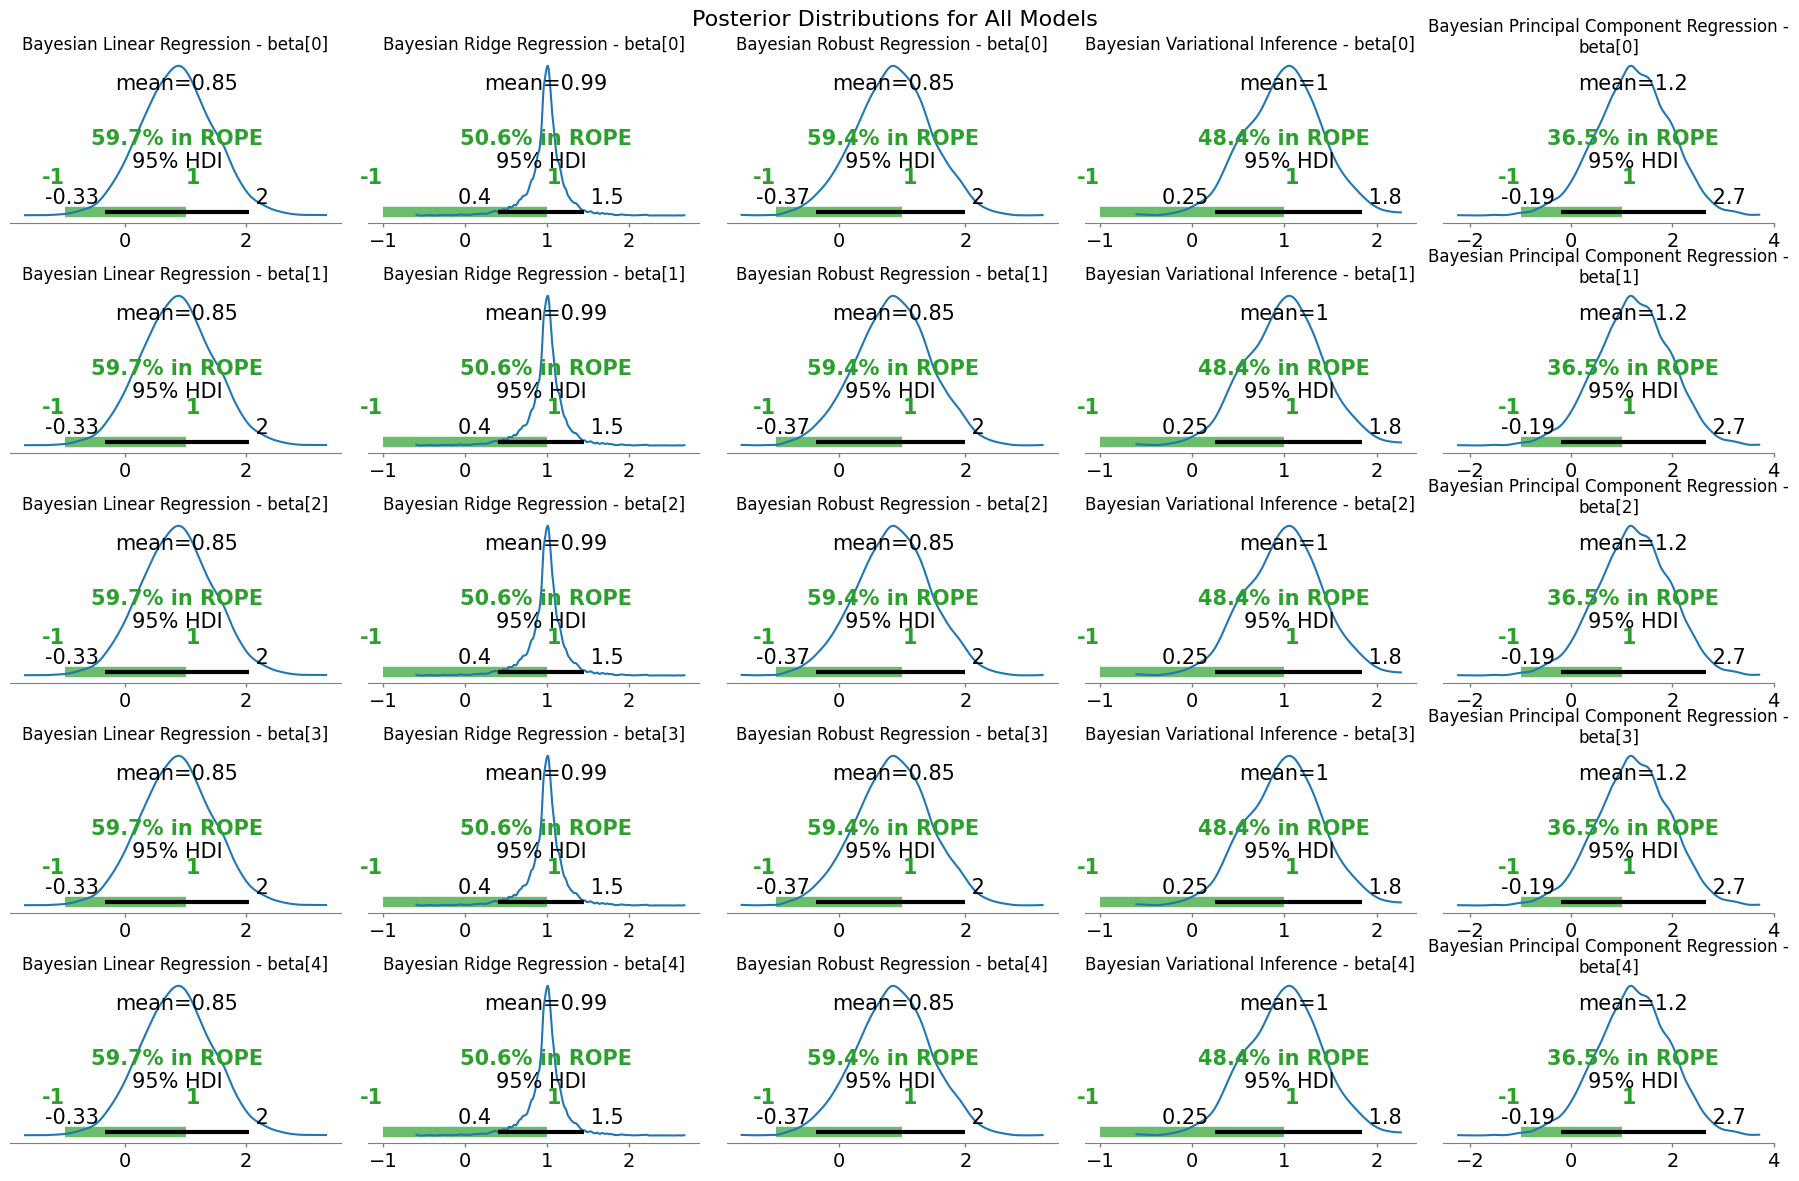

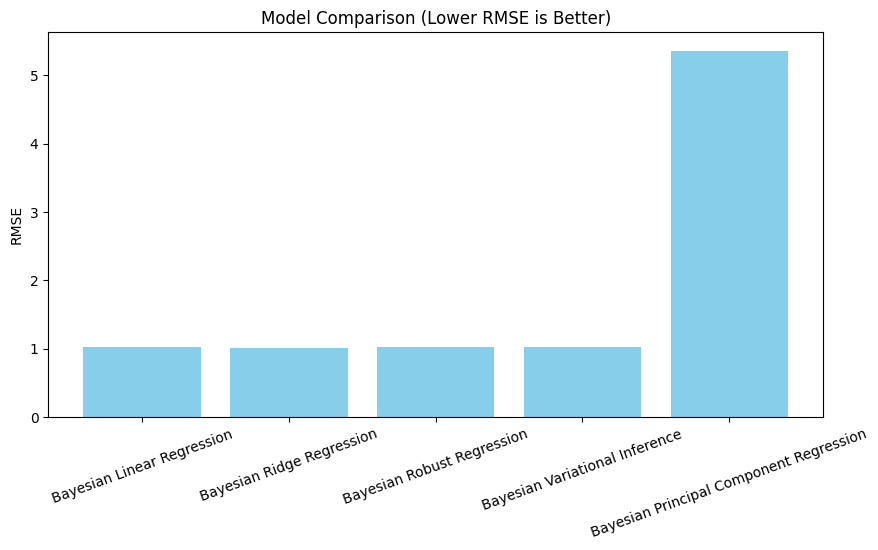

In [5]:
np.random.seed(410)
n=50
p = 5
# Create alternating columns of [0, 1] and [1, 0] in 3 columns to reduce experimental randomness
X = np.ones((n, p))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

# Create true_beta based on logspace
true_beta = np.logspace(0, 1, p, base=2)
sigma_true = 1
print(true_beta)

# Generate y with added random noise
y = np.dot(X, true_beta) + stats.norm(0,sigma_true).rvs(n)

run_and_plot_models(X, y, true_beta, n_components=2)

## Changing the sample size

Running models for sample size: 50


Output()

Output()

ERROR:pymc.stats.convergence:There were 256 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 100


Output()

Output()

ERROR:pymc.stats.convergence:There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models for sample size: 500


Output()

Output()

ERROR:pymc.stats.convergence:There were 300 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 1000


Output()

Output()

ERROR:pymc.stats.convergence:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 1500


Output()

Output()

ERROR:pymc.stats.convergence:There were 274 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

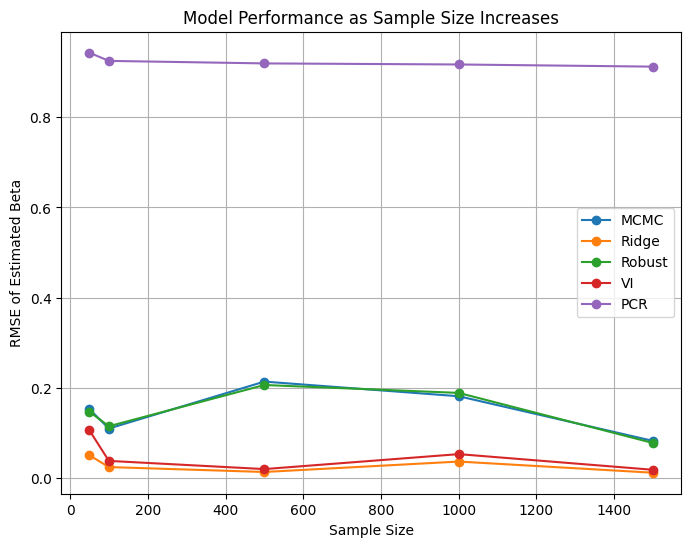

In [10]:
# Define sample sizes to test
sample_sizes = [50, 100, 500, 1000, 1500]
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for n in sample_sizes:
    print(f"Running models for sample size: {n}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(sample_sizes, rmse, marker='o', label=model)
plt.xlabel("Sample Size")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Sample Size Increases")
plt.legend()
plt.grid()
plt.show()

## Changing the number of parameters

In [ ]:
# Define sample sizes to test
p_numbers = [5, 20, 30, 50, 100]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

Running models for this many parameters: 5


Output()

Output()

ERROR:pymc.stats.convergence:There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 10


Output()

Output()

ERROR:pymc.stats.convergence:There were 116 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 20


Output()

Output()

ERROR:pymc.stats.convergence:There were 139 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 30


Output()

Output()

ERROR:pymc.stats.convergence:There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

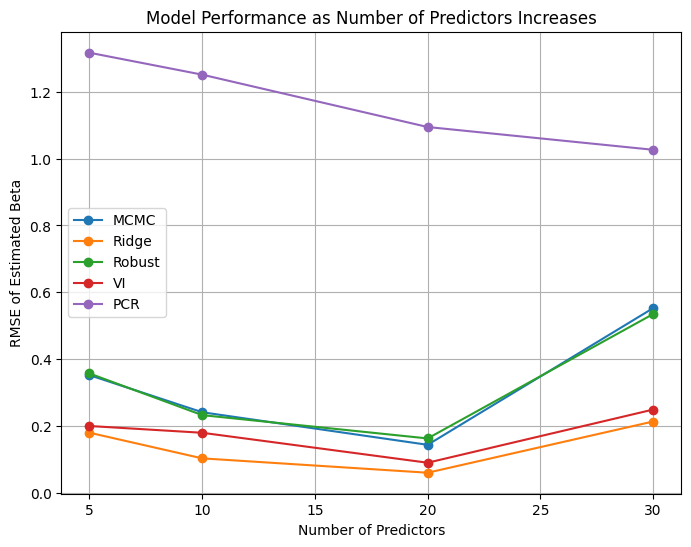

In [12]:
# Define sample sizes to test
p_numbers = [5, 20, 30, 50, 100]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

## Changing magnitudes

Running models with true_beta: [np.float64(1.0), 1, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 2, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 4, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 8, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 16, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

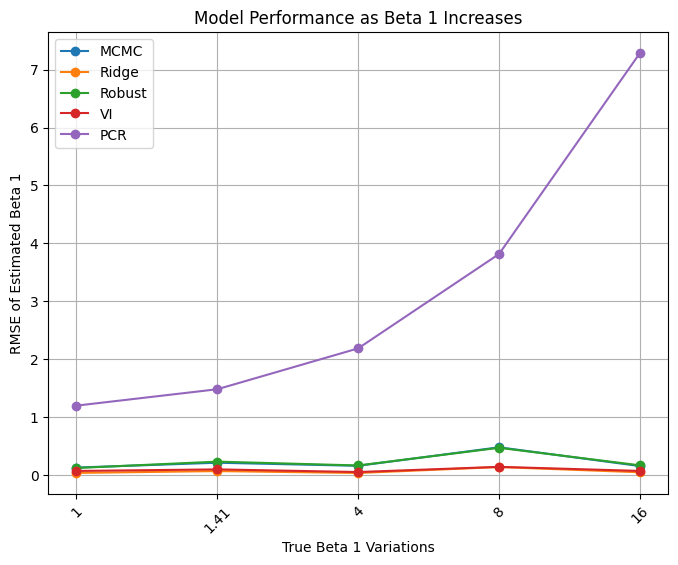

In [14]:
p=5
# Fixed 5-element true_beta array
true_beta = np.logspace(0, 1, p, base=2)

# Define different values where only one coefficient increases at a time
beta_variations = [ [true_beta[0], 2**i, *true_beta[2:]] for i in range(5)]


n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 1 Variations")
plt.ylabel("RMSE of Estimated Beta 1")
plt.title("Model Performance as Beta 1 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Define different values where only one coefficient increases at a time
p=5
# Fixed 5-element true_beta array
true_beta = np.logspace(0, 1, p, base=2)

beta_variations = [[2**i, *true_beta[1:]] for i in range(5)]


n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "2", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 0 Variations")
plt.ylabel("RMSE of Estimated Beta 0")
plt.title("Model Performance as Beta 0 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Running models with true_beta: [1, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [2, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [4, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

### Before PCR

Running models for sample size: 50


Output()

Output()

ERROR:pymc.stats.convergence:There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 100


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 500


Output()

Output()

ERROR:pymc.stats.convergence:There were 124 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1000


Output()

Output()

ERROR:pymc.stats.convergence:There were 144 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1500


Output()

Output()

ERROR:pymc.stats.convergence:There were 136 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

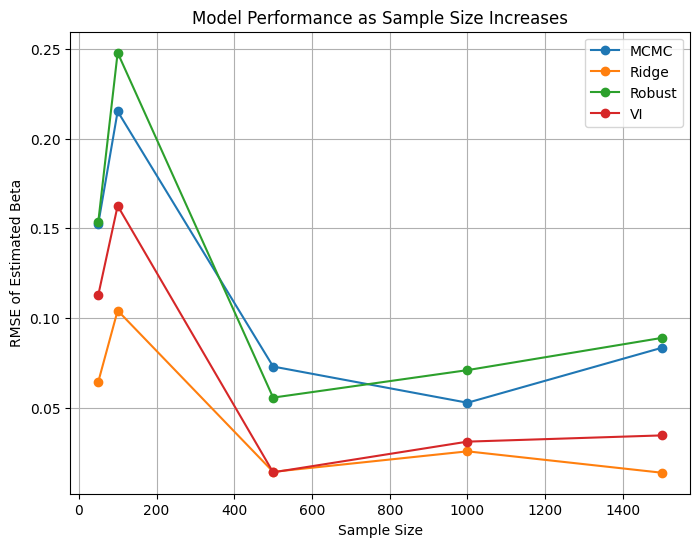

In [ ]:
# Define sample sizes to test
sample_sizes = [50, 100, 500, 1000, 1500]
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for n in sample_sizes:
    print(f"Running models for sample size: {n}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(sample_sizes, rmse, marker='o', label=model)
plt.xlabel("Sample Size")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Sample Size Increases")
plt.legend()
plt.grid()
plt.show()

Running models for this many parameters: 5
[1.         1.18920712 1.41421356 1.68179283 2.        ]
[[0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]]
[6.34313041 8.23862283 3.40327589 6.55677829 2.70763078 7.86717578
 2.55954932 6.91704153 3.04405375 7.51581882 0.98431795 6.06781911
 2.29043936 7.84471689 2.60464811 7.64656651 2.56546417 8.03525878
 4.57115549 6.11193809]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 10
[1.         1.08005974 1.16652904 1.25992105 1.36079    1.46973449
 1.58740105 1.71448797 1.85174942 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[14.17123287 13.45095174 11.80316809 13.9593039   9.36397084 12.84057616
 10.05979643 13.91879166  5.86469927 14.33416863  6.37577213 14.257566
  6.51794212 15.60022719  7.40053405 1

Output()

ERROR:pymc.stats.convergence:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 15
[1.         1.05075664 1.10408951 1.16012939 1.21901365 1.28088669
 1.34590019 1.41421356 1.48599429 1.56141836 1.64067071 1.72394564
 1.81144733 1.90339031 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1.

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 20
[1.         1.03715504 1.07569059 1.11565792 1.15711024 1.20010272
 1.24469259 1.2909392  1.3389041  1.38865114 1.44024654 1.49375896
 1.54925964 1.60682245 1.66652401 1.72844379 1.79266419 1.85927071
 1.928352   2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Output()

ERROR:pymc.stats.convergence:There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

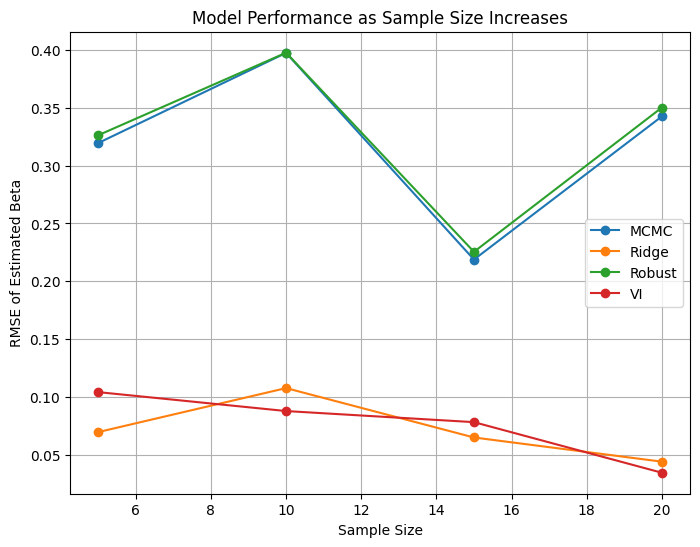

In [ ]:
# Define sample sizes to test
p_numbers = [5, 10, 15, 20]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

Running models with true_beta: [1, 1, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 148 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 4, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 557 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 8, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 16, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 420 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

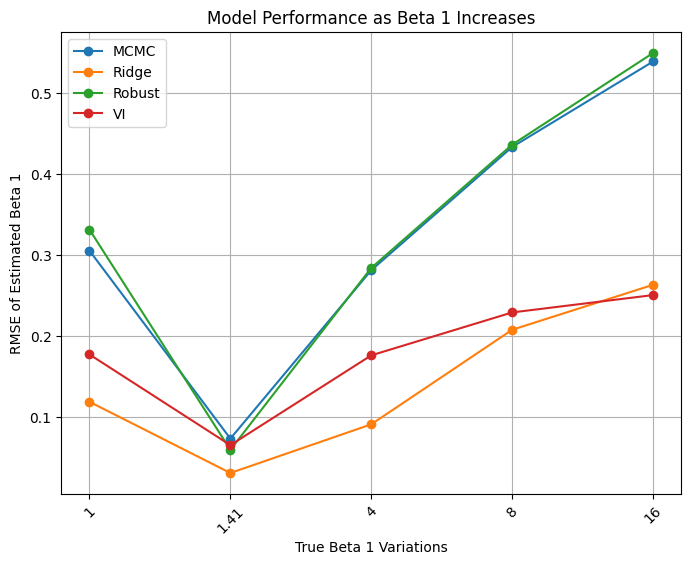

In [ ]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, 1, 2],
    [1, float(np.sqrt(2)), 2],
    [1, 4, 2],
    [1, 8, 2],
    [1, 16, 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 1 Variations")
plt.ylabel("RMSE of Estimated Beta 1")
plt.title("Model Performance as Beta 1 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 186 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [2, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [4, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 113 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [8, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [32, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

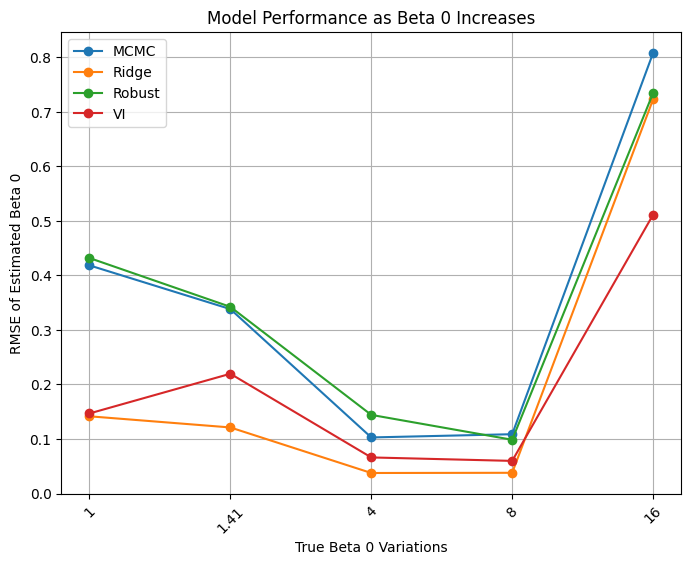

In [ ]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, float(np.sqrt(2)), 2],
    [2, float(np.sqrt(2)), 2],
    [4, float(np.sqrt(2)), 2],
    [8, float(np.sqrt(2)), 2],
    [32, float(np.sqrt(2)), 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 0 Variations")
plt.ylabel("RMSE of Estimated Beta 0")
plt.title("Model Performance as Beta 0 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
